In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy

from PIL import Image
from skimage import io, transform

In [2]:
device = torch.device("cuda")

In [54]:
def imagecombination(directory):
    features = []
    labels = []
    filenames_image = []
    for actor_number in os.listdir(directory):
        for videoes in os.listdir(directory + actor_number):

            for name in range(1,len(os.listdir(directory + actor_number + '/' + videoes))-1):
                    
                target_path = directory + actor_number + '/' +videoes + '/' + str(name*10) + ".jpg"
                image = io.imread(target_path)
                features.append(image)

                number = videoes.split("-")
                emotion = number[2]
                #if emotion == "01" or emotion == "02":
                if emotion =="01":
                    label = 4 #neutral
                elif emotion == "02":
                    label = 4 #"neutral"
                elif emotion == "03":
                    label = 3 #"happy"
                elif emotion == "04":
                    label = 5 #"sad"
                elif emotion == "05":
                    label = 0 #"angry"
                elif emotion == "06":
                    label = 2 #"fearful"
                elif emotion == "07":
                    label = 1 #"disgust"
                elif emotion == "08":
                    label = 6 #"surprised" 

                labels.append(label)


                filenames_image.append(videoes)

    return features, labels, filenames_image

In [55]:
class Image(Dataset):
    """MFCC from the audio."""

    def __init__(self, directory, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.directory = directory
        self.features, self.labels, self.filenames_image = imagecombination(directory)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx]
        transformed_image = self.transform(feature)
        label = self.labels[idx]
        filename_image = self.filenames_image[idx]
        sample = {'image': transformed_image, 'label': label, 'filename_image': filename_image}

        return sample

In [56]:
# prepare the form of the audio and load it into pytorch
dataset_train = Image(directory = "./Multimodal-Emotion-Recognition/image_data/train/",
                                           transform=transforms.Compose([
                                               transforms.ToPILImage(),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                           ]))

dataset_valid = Image(directory = "./Multimodal-Emotion-Recognition/image_data/valid/",
                                           transform=transforms.Compose([
                                               transforms.ToPILImage(),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])
                                           ]))

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4,
                        shuffle=True, num_workers=0)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4,
                        shuffle=True, num_workers=0)
dataloaders = {'train': dataloader_train, 'valid': dataloader_valid}

In [57]:
dataset_size_train = len(dataset_train)
dataset_size_valid = len(dataset_valid)
dataset_sizes = {'train': dataset_size_train, 'valid': dataset_size_valid}

In [20]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)
model_ft = alexnet
model_ft.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [21]:
## Lets freeze the first few layers. This is done in two stages 
# Stage-1 Freezing all the layers 
freeze_layers = 1
if freeze_layers:
    for i, param in model_ft.named_parameters():
        param.requires_grad = False

# Since imagenet as 1000 classes , We need to change our last layer according to the number of classes we have,
num_classes = 7
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Sequential(nn.Linear(num_ftrs,num_classes), nn.Softmax(dim = 1))
input_size = 224

# Stage-2 , Freeze all the layers till "Conv2d_4a_3*3"
ct = []
for name, param in model_ft.named_parameters():
    if "classifier.1.weight" in ct:
        param.requires_grad = True
    ct.append(name)     

In [22]:
# Create the optimizer if freeze layer before
params_to_update = model_ft.parameters()
print("Params to learn:")
freeze_layers = 1
if freeze_layers:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
            print("\t",name)

Params to learn:
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.0.weight
	 classifier.6.0.bias


In [23]:
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [24]:
device_cpu = torch.device("cpu")

In [25]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_loss_list = []
    epoch_acc_list = []

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for sample_batched in dataloaders[phase]:
                inputs = sample_batched['image']
                labels = sample_batched['label']
                inputs = inputs.to(device)
                labels = labels.long().to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                #print(labels)
                #print(preds)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            epoch_loss_list.append(epoch_loss)
            epoch_acc_list.append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.cuda.empty_cache()
        
        if epoch % 10 == 0:
            model.load_state_dict(best_model_wts)
            PATH = "./model_image_new{}.pth".format(epoch)
            torch.save(model.state_dict(), PATH)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_list, epoch_acc_list

In [26]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# the unfreezed parameter are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft, loss_list, acc_list = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=50)

Epoch 1/50
----------
train Loss: 1.9661 Acc: 0.1981
valid Loss: 1.9608 Acc: 0.2046

Epoch 2/50
----------
train Loss: 1.8580 Acc: 0.2931
valid Loss: 1.9035 Acc: 0.2484

Epoch 3/50
----------
train Loss: 1.8078 Acc: 0.3469
valid Loss: 1.8608 Acc: 0.2972

Epoch 4/50
----------
train Loss: 1.7901 Acc: 0.3676
valid Loss: 1.8727 Acc: 0.2848

Epoch 5/50
----------
train Loss: 1.7918 Acc: 0.3662
valid Loss: 1.8361 Acc: 0.3258

Epoch 6/50
----------
train Loss: 1.7884 Acc: 0.3687
valid Loss: 1.8544 Acc: 0.3069

Epoch 7/50
----------
valid Loss: 1.8553 Acc: 0.3065

Epoch 8/50
----------
train Loss: 1.7348 Acc: 0.4222
valid Loss: 1.8198 Acc: 0.3406

Epoch 9/50
----------
train Loss: 1.7258 Acc: 0.4307
valid Loss: 1.8159 Acc: 0.3442

Epoch 10/50
----------
train Loss: 1.7153 Acc: 0.4419
valid Loss: 1.8055 Acc: 0.3535

Epoch 11/50
----------
train Loss: 1.7088 Acc: 0.4479
valid Loss: 1.8242 Acc: 0.3369

Epoch 12/50
----------
train Loss: 1.7063 Acc: 0.4522
valid Loss: 1.7747 Acc: 0.3876

Epoch 13

In [37]:
#print(acc_list[0].cpu().numpy())
accuracy = []
for i in acc_list:
    acc = i.item()
    accuracy.append(round(acc,4))

In [45]:
print(loss_list)

[1.96609074707127, 1.9607904673721384, 1.8579752335195767, 1.9035321828956429, 1.8078151068233528, 1.8608143599901332, 1.7900510402599525, 1.8727238795724332, 1.7917922793449317, 1.836089540516726, 1.7884326393159113, 1.8544092738683322, 1.7834239987522322, 1.855316614994805, 1.7348024918780316, 1.8197558990821312, 1.7257777078889653, 1.8159019441648563, 1.715320782280263, 1.8055284302355508, 1.7088492089980678, 1.8242157692184096, 1.7063472477205244, 1.7747081585194109, 1.7004492727111358, 1.788741796686902, 1.697418288181914, 1.7994748080381051, 1.690327005971926, 1.7898897739050026, 1.6893972588404884, 1.7911494404489543, 1.6893356491134166, 1.7900747621114352, 1.6887259914230992, 1.7886314356931343, 1.683570234373652, 1.7808724166061471, 1.688345691830432, 1.7888738656373617, 1.6952473744390368, 1.7879429423863986, 1.6947756207203355, 1.783988267375577, 1.6943912741115457, 1.7872953469852149, 1.7066873910459779, 1.7870816599938177, 1.6966302473587889, 1.784079244719123, 1.701089708

In [43]:
filepath = "./facial_epoch_acc.txt"
import json
with open(filepath, 'w') as f:
    f.write(json.dumps(accuracy))

In [46]:
filepath = "./facial_epoch_loss.txt"
with open(filepath, 'w') as f:
    f.write(json.dumps(loss_list))

In [47]:
def test_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    right = 0
    confusion_matrix = np.zeros((7,7))
    #fig = plt.figure()
    
    # Speed up the computation
    with torch.no_grad():
        for sample_batched in dataloaders["train"]:
            inputs = sample_batched['image']
            labels = sample_batched['label']
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                #ax = plt.subplot(num_images//3, 3, images_so_far)
                #ax.axis('off')
                #ax.set_title('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]] ))
                #imshow(inputs.cpu().data[j])
                
                if preds[j] == labels[j]:
                    right += 1
                
                confusion_matrix[preds[j]][labels[j]] = confusion_matrix[preds[j]][labels[j]]+1
                
                #print('predicted: {}, label: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                #print(confusion_matrix)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    accuracy = right/num_images
                    print("Prediction Accuracy: {}%".format(accuracy*100))
                    #print(type(confusion_matrix))
                    return confusion_matrix
        model.train(mode=was_training)

In [48]:
confusion_matrix = test_model(model_ft,num_images = 1000)

Prediction Accuracy: 55.1%


In [49]:
confusion_sum = np.sum(confusion_matrix, axis = 1)
for i in range(7):
    for j in range(7):
        confusion_matrix[i][j] = confusion_matrix[i][j]/confusion_sum[i]

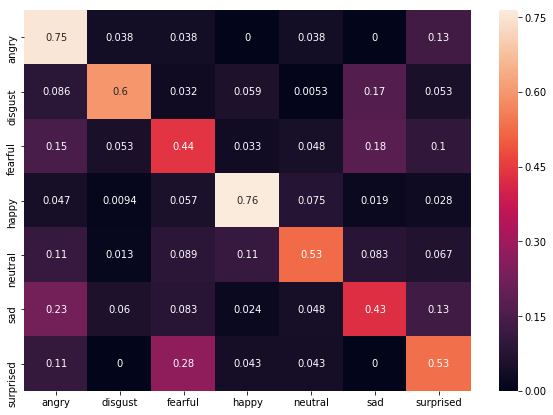

In [51]:
import seaborn as sn
import pandas as pd
class_names = ["angry","disgust","fearful","happy","neutral","sad","surprised"]

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [66]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    # Speed up the computation
    with torch.no_grad():
        for sample_batched in dataloaders["train"]:
            inputs = sample_batched['image']
            labels = sample_batched['label']
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            
            filename = sample_batched['filename_image']

            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if preds[j] != labels[j]:
                    images_so_far += 1
                    ax = plt.subplot(num_images//3, 3, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}, label: {}, file: {}, output: {}'.format(
                        class_names[preds[j]],class_names[labels[j]], filename[j], outputs[j]))
                    imshow(inputs.cuda().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        model.train(mode=was_training)

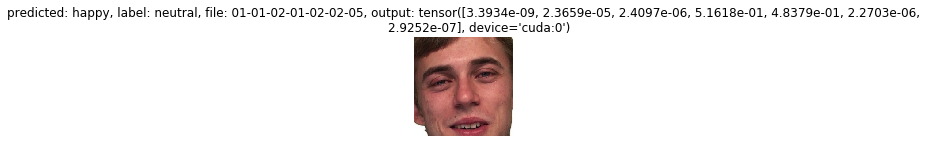

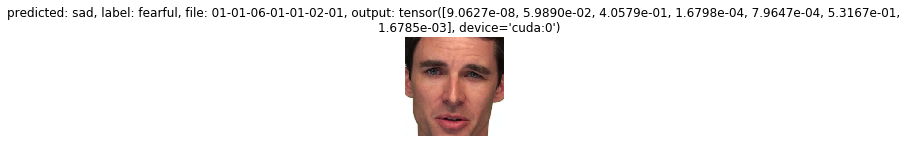

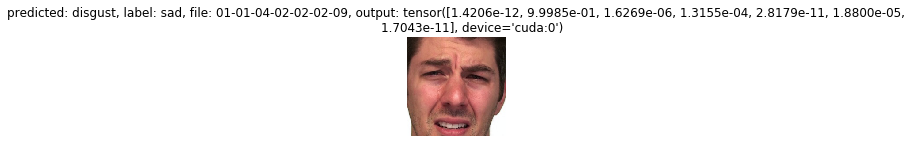

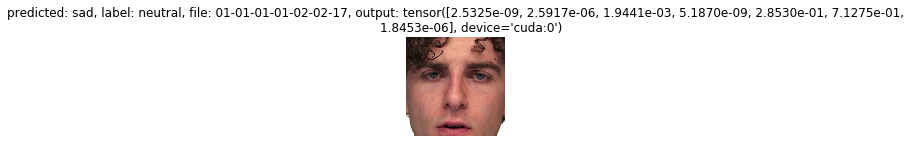

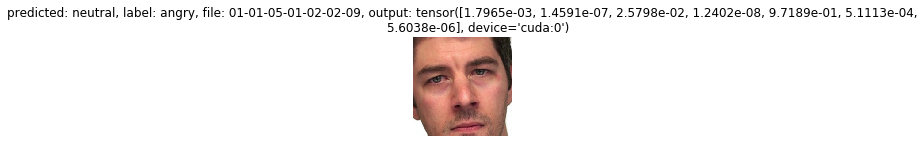

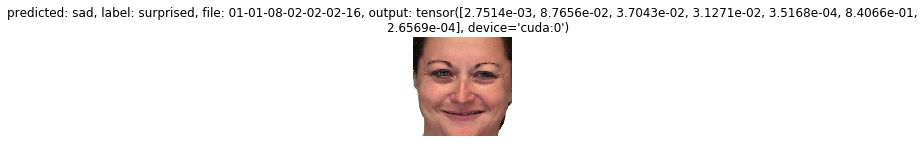

In [67]:
visualize_model(model_ft)